## Import Libraries

In [1]:
from scipy import io
import struct
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Dense, BatchNormalization

In [2]:
! unzip HODA

Archive:  HODA.zip
  inflating: Train 60000.cdb         
  inflating: RemainingSamples.cdb    
  inflating: Test 20000.cdb          


## Read cdb Dataset

In [3]:
def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels

In [4]:
print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb('/content/Train 60000.cdb')
print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb('/content/Test 20000.cdb')
print('Reading RemainingSamples.cdb ...')
remaining_images, remaining_labels = read_hoda_cdb('/content/RemainingSamples.cdb')

Reading Train 60000.cdb ...
Reading Test 20000.cdb ...
Reading RemainingSamples.cdb ...


## Visualize Some Data

----------------------------------------
type(train_images[ 0 ]): <class 'numpy.ndarray'>
train_images[ 0 ].dtype: uint8
train_images[ 0 ].min(): 0
train_images[ 0 ].max(): 255
train_images[ 0 ].shape = (HEIGHT, WIDTH): (27, 20)
type(train_labels[ 0 ]): <class 'int'>
train_labels[ 0 ]: 6
----------------------------------------
data matrix: 

[[  0   0   0   0 255 255   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0 255
  255   0]
 [  0 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0 255 255
  255 255]
 [  0 255 255 255 255   0   0   0   0   0   0   0   0   0   0 255 255 255
  255   0]
 [  0 255 255 255   0   0   0   0   0   0   0   0   0   0 255 255 255 255
  255   0]
 [255 255 255 255   0   0   0   0   0   0   0   0   0 255 255 255 255 255
    0   0]
 [255 255 255   0   0   0   0   0   0   0   0   0 255 255 25

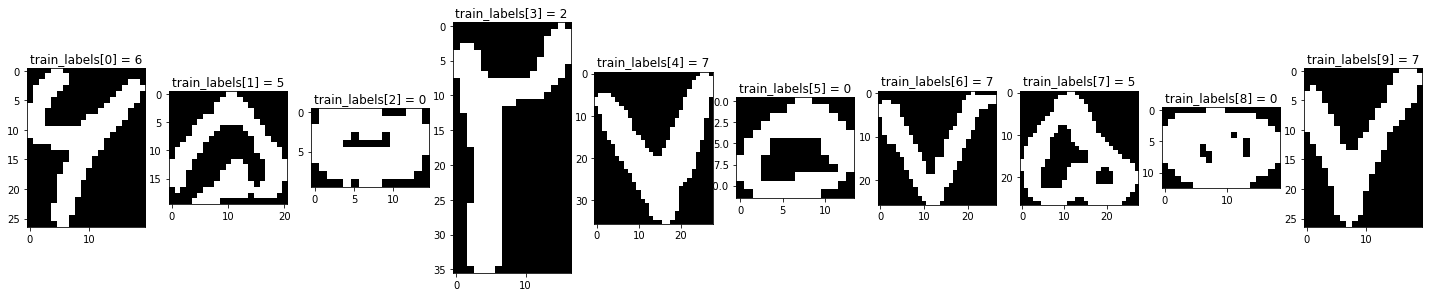

In [5]:
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    fig.add_subplot(1, 10, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(train_labels[i]))
    plt.imshow(train_images[i], cmap='gray')

print('----------------------------------------')
print('type(train_images[', 0, ']):', type(train_images[0]))
print('train_images[', 0, '].dtype:', train_images[0].dtype)
print('train_images[', 0, '].min():', train_images[0].min())
print('train_images[', 0, '].max():', train_images[0].max())
print('train_images[', 0, '].shape = (HEIGHT, WIDTH):', train_images[0].shape)
print('type(train_labels[', 0, ']):', type(train_labels[0]))
print('train_labels[', 0, ']:', train_labels[0])
print('----------------------------------------')
print('data matrix: \n')
print(train_images[0])
print('----------------------------------------')

plt.show()

## Split data to train and test and convert to 0/1

data matrix: 

[[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.

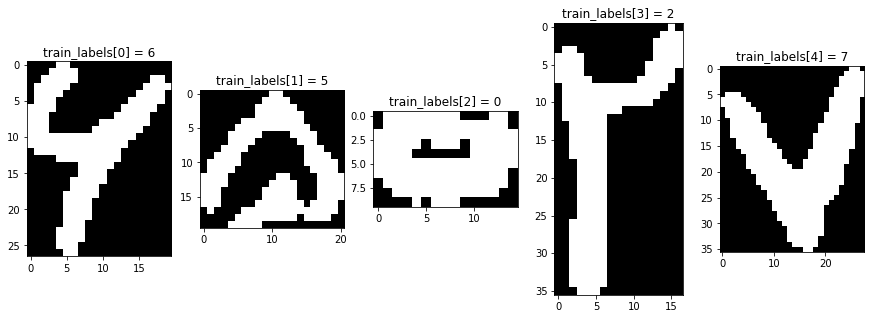

In [6]:
X_train, y_train = np.array(train_images, dtype=object), np.array(train_labels, dtype=object)
X_test, y_test = np.array(test_images, dtype=object), np.array(test_labels, dtype=object)
X_train /= 255
X_test /= 255

fig = plt.figure(figsize=(15, 5))
for i in range(5):
    fig.add_subplot(1, 5, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(y_train[i]))
    plt.imshow(X_train[i], cmap='gray')
print('data matrix: \n')
print(X_train[0])
plt.show()

## Resize images to 40*40

data matrix: 

[[0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.140625 0.046875 0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]]


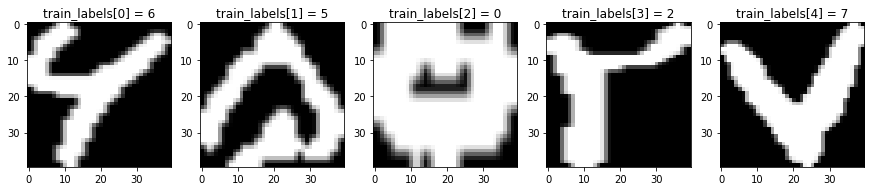

In [7]:
X_train = [cv2.resize(img, dsize=(40, 40)) for img in X_train]
X_test = [cv2.resize(img, dsize=(40, 40)) for img in X_test]

fig = plt.figure(figsize=(15, 5))
for i in range(5):
    fig.add_subplot(1, 5, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(y_train[i]))
    plt.imshow(X_train[i], cmap='gray')
print('data matrix: \n')
print(X_train[0])
plt.show()

In [8]:
#reshape
X_train = np.array([x.reshape(40*40) for x in X_train], dtype=object)
X_test = np.array([x.reshape(40*40) for x in X_test], dtype=object)

print(f'Train Shape: {X_train.shape}\nTest Shape: {X_test.shape}')

Train Shape: (60000, 1600)
Test Shape: (20000, 1600)


In [9]:
# 4. Preprocess class labels
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Reshape to match input of network

In [10]:
X_train = X_train.reshape(-1,40,40,1)
X_test = X_test.reshape(-1,40,40,1)

print(f'Train Shape: {X_train.shape}\nTest Shape: {X_test.shape}')

Train Shape: (60000, 40, 40, 1)
Test Shape: (20000, 40, 40, 1)


## Take a validation set

In [11]:
# test and validation set
X_val = X_test[200:]
X_test = X_test[:200]
y_val = y_test[200:]
y_test = y_test[:200]

## Evaluation measures

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Define model

## ADAM model

In [13]:
# Define model architecture
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', input_shape=(40, 40, 1), padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.3))

model.add(layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', recall_m, precision_m, f1_m])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 128)      5

In [15]:
# Fit model on training data
history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32),
          epochs=100, batch_size=256, validation_data = (X_val.astype(np.float32), y_val.astype(np.float32)))

Epoch 1/100
235/235 [==============================] - 22s 92ms/step - loss: 0.0028 - accuracy: 0.9993 - recall_m: 0.9993 - precision_m: 0.9993 - f1_m: 0.9993 - val_loss: 0.0279 - val_accuracy: 0.9952 - val_recall_m: 0.9952 - val_precision_m: 0.9953 - val_f1_m: 0.9952
Epoch 2/100
235/235 [==============================] - 22s 93ms/step - loss: 0.0018 - accuracy: 0.9995 - recall_m: 0.9995 - precision_m: 0.9995 - f1_m: 0.9995 - val_loss: 0.0209 - val_accuracy: 0.9962 - val_recall_m: 0.9962 - val_precision_m: 0.9963 - val_f1_m: 0.9962
Epoch 3/100
235/235 [==============================] - 22s 92ms/step - loss: 0.0040 - accuracy: 0.9989 - recall_m: 0.9989 - precision_m: 0.9989 - f1_m: 0.9989 - val_loss: 0.0392 - val_accuracy: 0.9928 - val_recall_m: 0.9928 - val_precision_m: 0.9930 - val_f1_m: 0.9929
Epoch 4/100
235/235 [==============================] - 21s 92ms/step - loss: 0.0037 - accuracy: 0.9990 - recall_m: 0.9990 - precision_m: 0.9990 - f1_m: 0.9990 - val_loss: 0.0233 - val_accuracy:

## Evaluation of model

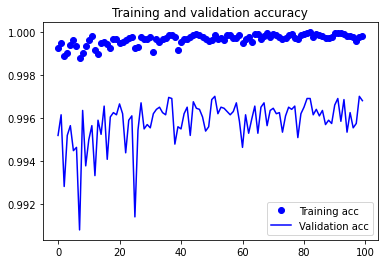

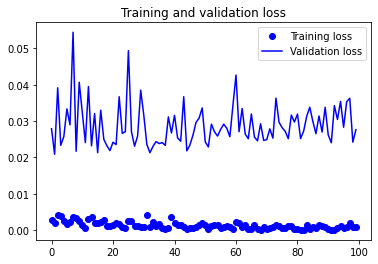

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
loss, acc, f1_score, precision, recall = model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.03787151724100113,

 ACCURACY: 0.9950000047683716,

 F1_SCORE: 0.9955357313156128,

 PRECISION: 0.9955357313156128,

 RECALL: 0.9955357313156128



## Run for remaining dataset

In [18]:
X_remain, y_remain = np.array(remaining_images, dtype=object), np.array(remaining_labels, dtype=object)
X_remain /= 255
X_remain = np.array([cv2.resize(img, dsize=(40, 40)) for img in X_remain], dtype=object)
y_remain = keras.utils.to_categorical(y_remain, num_classes=10)
X_remain = X_remain.reshape(-1,40,40,1)

In [19]:
loss, acc, f1_score, precision, recall = model.evaluate(X_remain.astype(np.float32), y_remain.astype(np.float32), verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.017765024676918983,

 ACCURACY: 0.9978078007698059,

 F1_SCORE: 0.9978093504905701,

 PRECISION: 0.9978093504905701,

 RECALL: 0.9978093504905701



<hr>

## MOMENTUM Model

In [21]:
import tensorflow as tf

# Define model architecture
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', input_shape=(40, 40, 1), padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.3))

model.add(layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.experimental.SGD(0.1, momentum=0.9),
              metrics=['accuracy', recall_m, precision_m, f1_m])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 batch_normalization_16 (Bat  (None, 40, 40, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 batch_normalization_17 (Bat  (None, 20, 20, 128)     

In [22]:
# Fit model on training data
history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32),
          epochs=100, batch_size=256, validation_data = (X_val.astype(np.float32), y_val.astype(np.float32)))

Epoch 1/100
235/235 [==============================] - 25s 93ms/step - loss: 0.2128 - accuracy: 0.9502 - recall_m: 0.9480 - precision_m: 0.9523 - f1_m: 0.9499 - val_loss: 0.4226 - val_accuracy: 0.9313 - val_recall_m: 0.9310 - val_precision_m: 0.9321 - val_f1_m: 0.9316
Epoch 2/100
235/235 [==============================] - 22s 93ms/step - loss: 0.0392 - accuracy: 0.9899 - recall_m: 0.9897 - precision_m: 0.9903 - f1_m: 0.9900 - val_loss: 0.0955 - val_accuracy: 0.9796 - val_recall_m: 0.9796 - val_precision_m: 0.9800 - val_f1_m: 0.9798
Epoch 3/100
235/235 [==============================] - 21s 91ms/step - loss: 0.0278 - accuracy: 0.9924 - recall_m: 0.9923 - precision_m: 0.9926 - f1_m: 0.9925 - val_loss: 0.0778 - val_accuracy: 0.9825 - val_recall_m: 0.9825 - val_precision_m: 0.9831 - val_f1_m: 0.9828
Epoch 4/100
235/235 [==============================] - 21s 91ms/step - loss: 0.0206 - accuracy: 0.9941 - recall_m: 0.9940 - precision_m: 0.9943 - f1_m: 0.9941 - val_loss: 0.0419 - val_accuracy:

## Evaluation of model

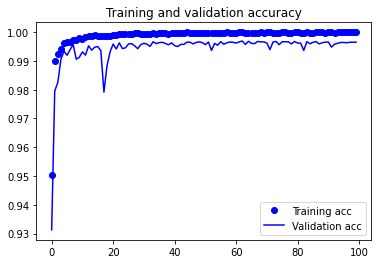

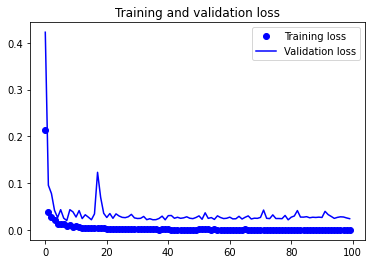

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
loss, acc, f1_score, precision, recall = model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.008223810233175755,

 ACCURACY: 0.9950000047683716,

 F1_SCORE: 0.9955357313156128,

 PRECISION: 0.9955357313156128,

 RECALL: 0.9955357313156128



## Run for remaining dataset

In [25]:
loss, acc, f1_score, precision, recall = model.evaluate(X_remain.astype(np.float32), y_remain.astype(np.float32), verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.018722204491496086,

 ACCURACY: 0.9975393414497375,

 F1_SCORE: 0.9975411295890808,

 PRECISION: 0.9975411295890808,

 RECALL: 0.9975411295890808



## ADADELTA Model

In [26]:
# Define model architecture
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', input_shape=(40, 40, 1), padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.3))

model.add(layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy', recall_m, precision_m, f1_m])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 batch_normalization_24 (Bat  (None, 40, 40, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 batch_normalization_25 (Bat  (None, 20, 20, 128)     

In [27]:
# Fit model on training data
history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32),
          epochs=100, batch_size=256, validation_data = (X_val.astype(np.float32), y_val.astype(np.float32)))

Epoch 1/100
235/235 [==============================] - 24s 95ms/step - loss: 3.4344 - accuracy: 0.1343 - recall_m: 0.0696 - precision_m: 0.1428 - f1_m: 0.0935 - val_loss: 2.6977 - val_accuracy: 0.0909 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/100
235/235 [==============================] - 22s 94ms/step - loss: 2.9661 - accuracy: 0.1996 - recall_m: 0.1188 - precision_m: 0.2317 - f1_m: 0.1570 - val_loss: 3.3169 - val_accuracy: 0.0934 - val_recall_m: 0.0897 - val_precision_m: 0.0906 - val_f1_m: 0.0902
Epoch 3/100
235/235 [==============================] - 22s 93ms/step - loss: 2.6119 - accuracy: 0.2598 - recall_m: 0.1702 - precision_m: 0.3138 - f1_m: 0.2205 - val_loss: 2.3732 - val_accuracy: 0.1929 - val_recall_m: 0.1451 - val_precision_m: 0.1737 - val_f1_m: 0.1521
Epoch 4/100
235/235 [==============================] - 22s 95ms/step - loss: 2.3192 - accuracy: 0.3174 - recall_m: 0.2247 - precision_m: 0.3871 - f1_m: 0.2842 - val_loss: 1.8148 - v

## Evaluation of model

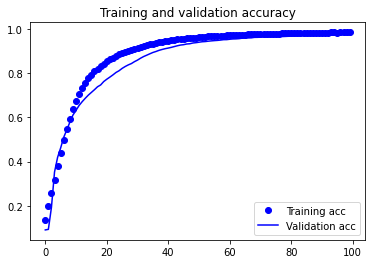

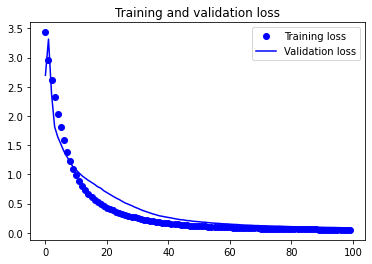

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
loss, acc, f1_score, precision, recall = model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.02179643325507641,

 ACCURACY: 0.9900000095367432,

 F1_SCORE: 0.9910714030265808,

 PRECISION: 0.9910714030265808,

 RECALL: 0.9910714030265808



## Run for remaining dataset

In [30]:
loss, acc, f1_score, precision, recall = model.evaluate(X_remain.astype(np.float32), y_remain.astype(np.float32), verbose=0)
print(f"\n LOSS: {loss},\n\n ACCURACY: {acc},\n\n F1_SCORE: {f1_score},\n\n PRECISION: {precision},\n\n RECALL: {recall}\n")


 LOSS: 0.06915955245494843,

 ACCURACY: 0.9791964888572693,

 F1_SCORE: 0.9780489802360535,

 PRECISION: 0.9804559350013733,

 RECALL: 0.9792314767837524

